# Calculate skill scores for offline tracer advection with ROMS



Results for paper:
* Plot of skill scores
* Plot showing several smaller results:
 * Plot persistence skill score for one example case
 * Forcing on and offline with opposite advection schemes
 * single vs double precision
* Just state in text:
 * his vs avg file forcing
 * tracer conservation
 * background value for Aks doesn't matter
* Summary plot


In [1]:
import xarray as xr
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from glob import glob
import pandas as pd
import os
import cartopy
import cmocean.cm as cmo
import netCDF4 as netCDF
import xgcm
from scipy import signal

chunks = {'ocean_time': 1}

/scratch/user/kthyng/.conda/envs/cart/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
import dask
from dask.distributed import Client

# client = Client(n_workers=7, threads_per_worker=2)#, memory_limit='20GB')
client = Client()#, memory_limit='20GB')
# client = Client(n_workers=1, threads_per_worker=7)  # i have multiple cores on one machine so use threads
client

Client Scheduler: tcp://127.0.0.1:41416 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 21.47 GB


In [3]:
baseon = '/scratch/group/csomio/CSOMIO/oil_03'
baseoff = '/scratch/group/csomio/CSOMIO/oil_off'

# plot parameters
fss = 12
fsm = 14
fsb = 16
ms = 150

iy = [10,75]; ix = [5,115]

tend = 13.5
ndays = 14

nhiss = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
dts = [1,2,5,10,20]
dtbase = 20
whichadvects = ['U3C4','MPDATA']
akss = [1e-6, 1e-3]  # vary background Aks values when Aks isn't being forced directly
aksflags = ['Akson', 'Aksoff']
clminputs = ['his', 'avg']

ind = np.arange(0, 13.5, 500*20/86400)

Lm, Mm, N = 250, 126, 50
nbytes = 8

# Functions

In [4]:
def calc_dyevol(ds):
    '''Calculate dye volume [m^3]'''
    ds = add_depths(ds)
    ds, grid = setup_grid(ds)  
    dz = grid.diff(ds.z_w, 's')
    dx = 1/ds.pm
    dy = 1/ds.pn
    dye = (ds['dye_01']*dx*dy*dz)
    return dye

def calc_subset(dye,dd=1):
    '''Return subset in space and decimated in time.
    
    Space is controlled by ix, iy indices.
    '''
    return dye.isel(ocean_time=slice(0,-1,dd), eta_rho=slice(iy[0],iy[1]), 
               xi_rho=slice(ix[0],ix[1]))


In [5]:

def calc_denom(locon, which, save=False):
    '''Calculate denominator of skill score.
    
    Options for whether regular or compared to persistence of initial condition.'''
    if save:
        if which == 'regular':
            denomname = '%s_denom.csv' % locon
        elif which == 'persistence':
            denomname = '%s_denom_persist.csv' % locon
        
    if save and os.path.exists(denomname):
        denom = pd.read_csv(denomname, index_col='ocean_time')
    else:
        if '.nc' in locon:
            # hasn't been processed yet
            dson = xr.open_dataset(locon, decode_times=False)
            dyeon = calc_dyevol(dson)
            dyeonsub = calc_subset(dyeon).to_dataset(name='dye_01')
        else:
            dyeonsub = xr.open_zarr(locon, decode_times=False)
        
        if which == 'regular':
            # calculate denominator for skill score 
            denom = np.sqrt(((dyeonsub.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))
        elif which == 'persistence':
            # compare online vs initial time step for persistence as a climatology
            denom = np.sqrt(((dyeonsub.dye_01.isel(ocean_time=0) - dyeonsub.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

        denom = denom.to_dataframe(name='denom')
        if save:
            # save 
            denom.to_csv(denomname)  
            dson.close()
    return denom

    
def calc_num(locon, locoff, save=False):
    '''Calculate numerator of skill score.'''
    if save:
        numname = '%s_num.csv' % locoff.split('.')[0]

    if save and os.path.exists(numname):
        num = pd.read_csv(numname, index_col='ocean_time')
    else:

        if '.nc' in locon:
            # hasn't been processed yet
            dson = xr.open_dataset(locon, decode_times=False)
            dyeon = calc_dyevol(dson)
            dyeonsub = calc_subset(dyeon)
        else:
            dson = xr.open_zarr(locon, decode_times=False)
            dyeonsub = dson.dye_01
        
        if '.nc' in locoff:
            dsoff = xr.open_dataset(locoff, decode_times=False)
            dyeoff = calc_dyevol(dsoff)
            dyeoffsub = calc_subset(dyeoff)
            # interpolate to match online run
            dyeoffsub = dyeoffsub.interp(ocean_time=dson.ocean_time) \
                        .sel(ocean_time=slice(dson.ocean_time[0],dson.ocean_time[-1]))      
        else:
            dsoff = xr.open_zarr(locoff, decode_times=False)
            dyeoffsub = dsoff.dye_01

            
        num = np.sqrt(((dyeoffsub - dyeonsub)**2).mean(('s_rho','eta_rho', 'xi_rho')))
        num = num.to_dataframe(name='num')
        if save:
            num.to_csv(numname)
        dsoff.close()
    return num


def calc_ss(num, denom, save=False, ssname=None):
    '''Calculate skill score.'''

    if save and os.path.exists(ssname):
        skill = pd.read_csv(ssname, index_col='ocean_time')
    else:
        skill = (1-num/denom.values)*100
        skill.index = (skill.index - skill.index[0])/86400
        if save:
            skill.to_csv(ssname)
    return skill

def find_name(loc):
    '''Return name to use as column from simulation path.'''
    # find column name
    if 'oil_off' in loc:
        if 'Aksbak' in loc:
            whichadvect, aksflag, Aksbak, clminput, nhispart, dtpart = loc.split('/')[7:]
            name = '%s_%s_%s_%s_%s_%s' % (whichadvect, aksflag, Aksbak, clminput, nhispart, 
                                                dtpart.split('_')[-1].split('.')[0])
        else:
            whichadvect, aksflag, clminput, nhispart, dtpart = loc.split('/')[7:]
            name = '%s_%s_%s_%s_%s' % (whichadvect, aksflag, clminput, nhispart, 
                                                dtpart.split('_')[-1].split('.')[0])
    elif 'oil_03' in loc:
        whichadvect, nhispart, clmpart = loc.split('/')[7:]
        clm = clmpart.split('_')[2]  
        name = '%s_%s_%s' % (whichadvect, nhispart, clm)
    return name


def newcol(locoff, ss, which):
    
    colname = find_name(locoff) + '_' + which
    
    # create cols
    ss = ss.reindex(ind).interpolate('index')  # made sure times match here

    return colname, ss['num'].values

In [6]:
def add_depths(ds):
#     Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
#     z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho', transpose_coords=False)
#     ds.coords['z_rho'] = z_rho.transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho', transpose_coords=False)
    return ds

def setup_grid(ds):
    # Create the grid
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
        'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
        's':{'center':'s_rho', 'outer':'s_w'}}

    grid = xgcm.Grid(ds, coords=coords, periodic=[])
    return ds, grid

In [7]:
num2d = 3  # zeta, ubar, vbar
def calc_storage(LmMm, N, num3d, nbytes):#, nhis):
    '''Calculate amount of storage required for simulation choices.
    
    nhis: How often to save output, by multiples of online time steps.
    returns as GB
    
    '''
    return (LmMm*num2d + LmMm*N*num3d)*nbytes/1e9

In [8]:
def fnhis(nhis):
    return 1/(nhis*20)

# Scales to use for normalization

In [9]:
# example model output to use for a few things
locon = '/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis500/oil_03_his.nc'
ds = xr.open_dataset(locon, decode_times=False, chunks=chunks)
ds['ocean_time'] = (ds.ocean_time - ds.ocean_time[0])/86400

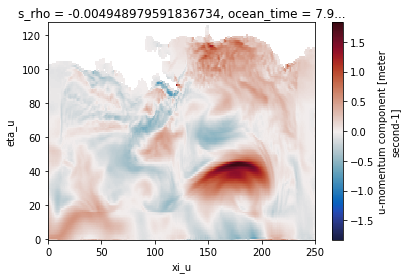

In [10]:
ds.u.isel(s_rho=-1).sel(ocean_time=8, method='nearest').plot(cmap=cmo.balance)

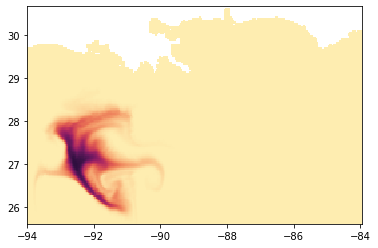

In [11]:
plt.pcolormesh(ds.lon_rho, ds.lat_rho, ds.dye_01.isel(s_rho=-1).sel(ocean_time=8, method='nearest'), cmap=cmo.matter)

In [12]:
L = 10000  # m
U = 0.5  # m/s

T = L/U  # normalized advection time in seconds
T

20000.0

## Courant numbers

U*dt/dx, w*dt/dz

In [13]:
ds = add_depths(ds)
ds, grid = setup_grid(ds)  
dz = grid.diff(ds.z_w, 's')
dx = 1/ds.pm
dy = 1/ds.pn

U = 1
dtss = np.array([1, 2, 5, 10, 20, 50])*20
DX = min(dx.min(), dy.min()).values
DZ = dz.min().values
W = 0.01

In [14]:
DX, DX

(array(3825.41532983), array(3825.41532983))

In [15]:
Cxs = [U*dt/DX for dt in dtss]
Czs = [W*dt/DZ for dt in dtss]

In [16]:
Cxs, Czs

([0.005228190477521378,
  0.010456380955042756,
  0.026140952387606893,
  0.052281904775213786,
  0.10456380955042757,
  0.2614095238760689],
 [6.780990472939388,
  13.561980945878776,
  33.90495236469694,
  67.80990472939388,
  135.61980945878776,
  339.04952364696936])

# Map of initial dye blob

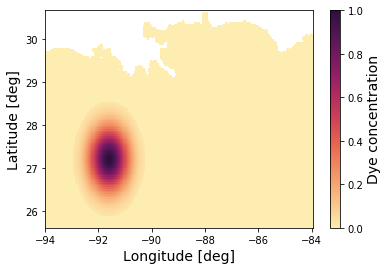

In [17]:
plt.pcolormesh(ds.lon_rho, ds.lat_rho, ds.dye_01.isel(s_rho=-1).sel(ocean_time=0, method='nearest'), cmap=cmo.matter)
cb = plt.colorbar()
cb.set_label('Dye concentration', fontsize=fsm)
plt.xlabel('Longitude [deg]', fontsize=fsm)
plt.ylabel('Latitude [deg]', fontsize=fsm)

plt.savefig('figures/map_low.png', bbox_inches='tight', dpi=100)
plt.savefig('figures/map.png', bbox_inches='tight', dpi=300)

# Skill scores

## Find lists of file locations

Set lists up in order for looping over later.

In [18]:
locson = []; locsoff = []

# Put together lists of locations to compare with skill score
for clminput in clminputs:
    for whichadvect in whichadvects:
        for i, nhis in enumerate(nhiss):
            locon = '%s/output_ss/%s/nhis%i/oil_03_%s' % (baseon,whichadvect,nhis,clminput)
            
            # loop over sim time step
            for dt in dts:
                
                if dt>nhis:
                    continue
                elif nhis == 50 and dt == 20:
                    continue
                elif nhis == 5 and dt == 2:
                    continue

                # Aks forcing can be turned on or off
                for aksflag in aksflags:
                    if aksflag == 'Aksoff':
                        for aks in akss:

                            exp = int(abs(np.log10(aks)))
                            outdir = '%s/output_ss/%s/%s/Aksbak%i/%s/nhis%i' % (baseoff,whichadvect,aksflag,exp,clminput,nhis)                                
                            locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                            print(locoff)
                            if not os.path.exists(locoff):
                                print('%s does not exist\n' % locoff)
                            else:
                                # always append locson at same time as locsoff to match one to one
                                locson.append(locon)
                                locsoff.append(locoff)
                    else:
                        outdir = '%s/output_ss/%s/%s/%s/nhis%i' % (baseoff,whichadvect,aksflag,clminput,nhis)
                        locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                        print(locoff)
                        if not os.path.exists(locoff):
                            print('%s does not exist\n' % locoff)
                        else:
                            # always append locson at same time as locsoff to match one to one
                            locson.append(locon)
                            locsoff.append(locoff)


/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis1/oil_off_his_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_of

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt10.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis100/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis100/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt20.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis200/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis200/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt1.nc 

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis5000/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis5000/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis5000/oil_off_his_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis5000/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis5000/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis5000/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis5000/oil_off_his_dt2.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis5000/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis5000/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis5000/oil_off_his_dt5

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis200/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis200/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis200/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis200/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis200/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis200/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt5.nc
/scratch/group/csomio/CSOM

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis5000/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis5000/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis5000/oil_off_his_dt20.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis1/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis1/oil_off_avg_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/avg/nhis1/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/avg/nhis1/oil_off_avg_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/avg/nhis1/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/avg/nhis1/oil_off_avg_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis2/oil_

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis2/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis2/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis2/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis2/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis5/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis5/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis5/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis5/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis5/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis5/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis500/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis500/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis500/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis500/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis500/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis1000/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis1000/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis1000/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis1000/oil_off_avg_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis1000/oil_off_avg_dt2.nc
/

First downscale all the online files, which have potential very high output rates.

In [19]:
for locon in set(locson):
    nhis = int(locson[0].split('/')[8].split('nhis')[1])

    if nhis > 500:  # for nhis=1000,2000,5000, output is at that frequency which is lower than 500
        dd = 1
    else:
        dd = int(500/nhis)
    zarrname = locon.split('.')[0]
    
    if not os.path.exists(zarrname):  # don't redo
        print('processing %s...' % zarrname)
        dson = xr.open_dataset(locon, decode_times=False, chunks=chunks);
        dyeon = calc_dyevol(dson)
        dyeonsub = calc_subset(dyeon,dd)
        dyeonsub.to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
    else:
        print('already done with %s, moving on.' % zarrname)


already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2/oil_03_his, moving on.
already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his, moving on.
already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis20/oil_03_his, moving on.
already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2/oil_03_avg, moving on.
already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5/oil_03_his, moving on.
already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_his, moving on.
already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2000/oil_03_his, moving on.
already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1000/oil_03_his, moving on.
already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1000/oil_03_avg, moving on.
already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_his, movin

## Calculate skill scores

Calculate skill scores and persistence skill scores for all offline simulations compared with online and put into dataframe `df`.

In [20]:
cols = np.zeros((ind.size, len(locson)))
colnames = []
colsp = np.zeros((ind.size, len(locson)))
colnamesp = []
for i, (locon, locoff) in enumerate(zip(locson, locsoff)):
    print(locon, locoff)

    ## calculate denominator from online output ##
    denom = calc_denom(locon, 'regular', save=True)
    denomp = calc_denom(locon, 'persistence', save=True)
    
    # calculate numerator
    num = calc_num(locon, locoff, save=True)
    
    # calculate skill scores
    ssname = '%s_ss.csv' % locoff.split('.')[0]
    ss = calc_ss(num, denom, save=True, ssname=ssname)
    ssname = '%s_ss_persist.csv' % locoff.split('.')[0]
    ssp = calc_ss(num, denomp, save=True, ssname=ssname)
    
    # create new col containing skill score
    name, col = newcol(locoff, ss, 'reg')
    cols[:,i] = col
    colnames.append(name)
    name, col = newcol(locoff, ssp, 'persist')
    colsp[:,i] = col
    colnamesp.append(name)

df = pd.DataFrame(index=ind, data=np.concatenate((cols,colsp), axis=1), columns=colnames+colnamesp)
df.to_csv('output_ss/df.csv')
df['days'] = df.index
df.index = df.index*86400/T  # normalize time by dynamic time scale
df

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis200/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis200/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis200/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis200/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis200/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis200/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis500/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt2.nc
/scratch/group/c

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis5/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis5/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis5/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis5/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis5/oil_off_his_dt5.nc
/scratch/g

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis100/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis100/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis100/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis100/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis100/oil

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis2000/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis2000/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis2000/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis2000/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis2000/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis2000/oi

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis20/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis20/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis20/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis20/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis20/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis20/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis20/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis20/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis20/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis20/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis20/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis20/oil_off_avg_dt5.n

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis200/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis200/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis200/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis200/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis200/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis500/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis500/

,U3C4_Akson_his_nhis1_dt1_reg,U3C4_Aksoff_Aksbak6_his_nhis1_dt1_reg,U3C4_Akson_his_nhis2_dt1_reg,U3C4_Aksoff_Aksbak6_his_nhis2_dt1_reg,U3C4_Akson_his_nhis2_dt2_reg,U3C4_Aksoff_Aksbak6_his_nhis2_dt2_reg,U3C4_Akson_his_nhis5_dt1_reg,U3C4_Aksoff_Aksbak6_his_nhis5_dt1_reg,U3C4_Akson_his_nhis5_dt5_reg,U3C4_Aksoff_Aksbak6_his_nhis5_dt5_reg,...,MPDATA_Aksoff_Aksbak6_avg_nhis5000_dt1_persist,MPDATA_Akson_avg_nhis5000_dt2_persist,MPDATA_Aksoff_Aksbak6_avg_nhis5000_dt2_persist,MPDATA_Akson_avg_nhis5000_dt5_persist,MPDATA_Aksoff_Aksbak6_avg_nhis5000_dt5_persist,MPDATA_Akson_avg_nhis5000_dt10_persist,MPDATA_Aksoff_Aksbak6_avg_nhis5000_dt10_persist,MPDATA_Akson_avg_nhis5000_dt20_persist,MPDATA_Aksoff_Aksbak6_avg_nhis5000_dt20_persist,days
0.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0.000000
0.5,99.995411,99.987793,99.995411,99.987793,99.995411,99.987793,99.995411,99.987793,99.995411,99.987793,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0.115741
1.0,99.990823,99.975586,99.990823,99.975586,99.990822,99.975586,99.990823,99.975586,99.990822,99.975586,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0.231481
1.5,99.986234,99.963379,99.986234,99.963379,99.986234,99.963379,99.986234,99.963379,99.986233,99.963379,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0.347222
2.0,99.982296,99.949052,99.982296,99.949052,99.982296,99.949052,99.982296,99.949052,99.982294,99.949051,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0.462963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56.0,99.622409,97.551632,99.622409,97.551632,99.622408,97.551633,99.622408,97.551632,99.622402,97.551635,...,63.427347,63.680118,63.436725,63.707485,63.464341,63.751548,63.509457,63.836478,63.596157,12.962963
56.5,99.619564,97.559178,99.619564,97.559178,99.619562,97.559179,99.619563,97.559178,99.619557,97.559182,...,63.427347,63.680118,63.436725,63.707485,63.464341,63.751548,63.509457,63.836478,63.596157,13.078704
57.0,99.616718,97.566724,99.616718,97.566724,99.616717,97.566725,99.616717,97.566725,99.616711,97.566728,...,63.427347,63.680118,63.436725,63.707485,63.464341,63.751548,63.509457,63.836478,63.596157,13.194444
57.5,99.613877,97.567743,99.613877,97.567743,99.613876,97.567744,99.613877,97.567743,99.613871,97.567746,...,63.427347,63.680118,63.436725,63.707485,63.464341,63.751548,63.509457,63.836478,63.596157,13.310185


### Print out final skill score for a large subset of runs

Don't show avg runs or multiple background Aks value runs

In [21]:
pd.set_option('display.max_rows', None)
cols = [col for col in df.columns if 'dt50' not in col and 'Aksbak3' not in col and 'avg' not in col]
print(df[cols].iloc[-1])
pd.set_option('display.max_rows', 6)

U3C4_Akson_his_nhis1_dt1_reg                       99.611172
U3C4_Aksoff_Aksbak6_his_nhis1_dt1_reg              97.568877
U3C4_Akson_his_nhis2_dt1_reg                       99.611172
U3C4_Aksoff_Aksbak6_his_nhis2_dt1_reg              97.568877
U3C4_Akson_his_nhis2_dt2_reg                       99.611171
U3C4_Aksoff_Aksbak6_his_nhis2_dt2_reg              97.568878
U3C4_Akson_his_nhis5_dt1_reg                       99.611171
U3C4_Aksoff_Aksbak6_his_nhis5_dt1_reg              97.568877
U3C4_Akson_his_nhis5_dt5_reg                       99.611165
U3C4_Aksoff_Aksbak6_his_nhis5_dt5_reg              97.568880
U3C4_Akson_his_nhis10_dt1_reg                      99.611171
U3C4_Aksoff_Aksbak6_his_nhis10_dt1_reg             97.568877
U3C4_Akson_his_nhis10_dt2_reg                      99.611170
U3C4_Aksoff_Aksbak6_his_nhis10_dt2_reg             97.568878
U3C4_Akson_his_nhis10_dt5_reg                      99.611165
U3C4_Aksoff_Aksbak6_his_nhis10_dt5_reg             97.568880
U3C4_Akson_his_nhis10_dt

## Plot

Plot selections of skill scores for comparison between important parameters.



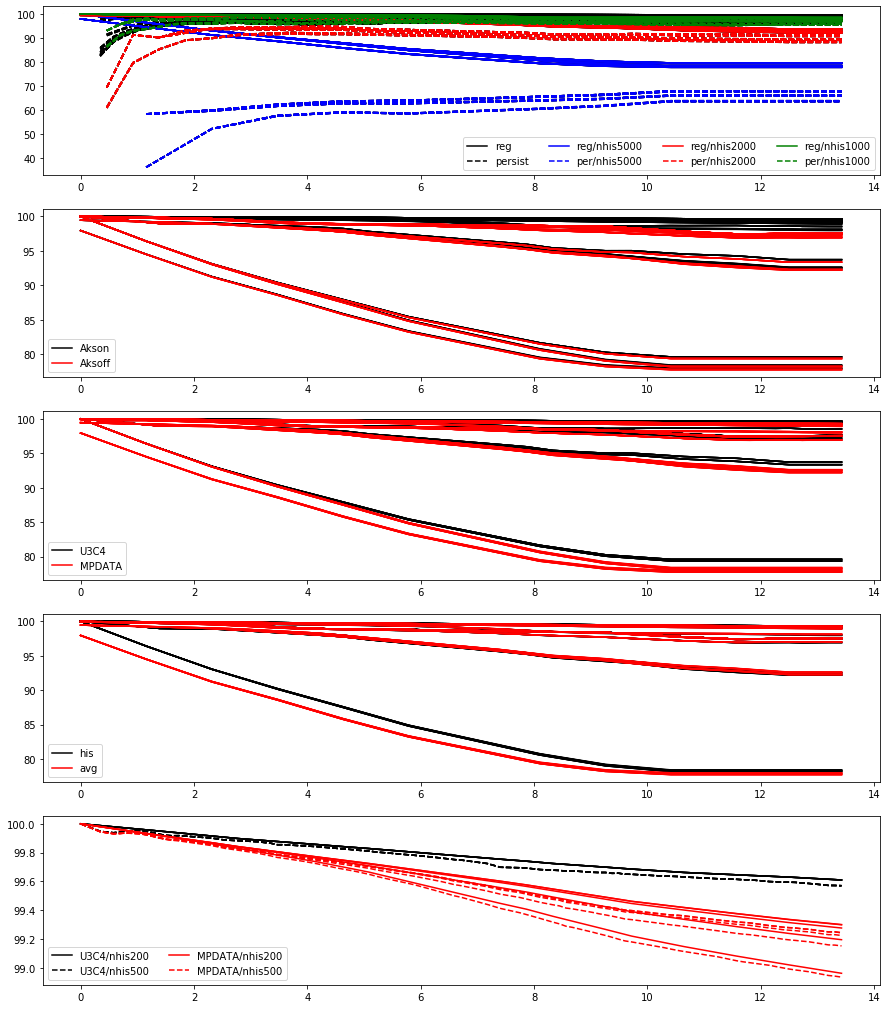

In [22]:
fig, axes = plt.subplots(5,1, figsize=(15,18))


cols1per = [col for col in df.columns if 'dt50' not in col and 'persist' in col]
cols1per5000 = [col for col in cols1per if 'nhis5000' in col]
cols1per2000 = [col for col in cols1per if 'nhis2000' in col]
cols1per1000 = [col for col in cols1per if 'nhis1000' in col]
cols1reg = [col for col in df.columns if 'dt50' not in col and 'reg' in col]
cols1reg5000 = [col for col in cols1reg if 'nhis5000' in col]
cols1reg2000 = [col for col in cols1reg if 'nhis2000' in col]
cols1reg1000 = [col for col in cols1reg if 'nhis1000' in col]

lsper = '--'; lsreg = '-'
col5000 = 'b'; col2000 = 'r'; col1000 = 'g'

ax = axes[0]
ax.plot(df['days'], df[cols1reg], color='k', ls=lsreg)
ax.plot([], label="reg", color='k', ls=lsreg)  
ax.plot(df['days'], df[cols1per], color='k', ls=lsper)
ax.plot([], label="persist", color='k', ls=lsper)  

ax.plot(df['days'], df[cols1reg5000], color=col5000, ls=lsreg)
ax.plot([], label="reg/nhis5000", color=col5000, ls=lsreg)  
ax.plot(df['days'], df[cols1per5000], color=col5000, ls=lsper)
ax.plot([], label="per/nhis5000", color=col5000, ls=lsper)  

ax.plot(df['days'], df[cols1reg2000], color=col2000, ls=lsreg)
ax.plot([], label="reg/nhis2000", color=col2000, ls=lsreg)  
ax.plot(df['days'], df[cols1per2000], color=col2000, ls=lsper)
ax.plot([], label="per/nhis2000", color=col2000, ls=lsper)  

ax.plot(df['days'], df[cols1reg1000], color=col1000, ls=lsreg)
ax.plot([], label="reg/nhis1000", color=col1000, ls=lsreg)  
ax.plot(df['days'], df[cols1per1000], color=col1000, ls=lsper)
ax.plot([], label="per/nhis1000", color=col1000, ls=lsper)  

ax.legend(ncol=4, loc='lower right')


ax = axes[1]
cols21 = [col for col in df.columns if 'dt50' not in col and 'reg' in col and 'Akson' in col]
cols22 = [col for col in df.columns if 'dt50' not in col and 'reg' in col and 'Aksoff' in col]
ax.plot(df['days'], df[cols21], color='k')
ax.plot([], label="Akson", color='k')
ax.plot(df['days'], df[cols22], color='r');
ax.plot([], label="Aksoff", color='r')
ax.legend()


ax = axes[2]
cols3a = [col for col in df.columns if 'dt50' not in col and 'reg' in col and 'MPDATA' in col]
cols3b = [col for col in df.columns if 'dt50' not in col and 'reg' in col and 'U3C4' in col]
ax.plot(df['days'], df[cols3b], color='k');
ax.plot([], label="U3C4", color='k')
ax.plot(df['days'], df[cols3a], color='r')
ax.plot([], label="MPDATA", color='r')
ax.legend()


ax = axes[3]
cols4a = [col for col in df.columns if 'dt50' not in col and 'reg' in col and 'MPDATA' in col and '_his_' in col]
cols4b = [col for col in df.columns if 'dt50' not in col and 'reg' in col and 'MPDATA' in col and 'avg' in col]
ax.plot(df['days'], df[cols4a], color='k');
ax.plot([], label="his", color='k')
ax.plot(df['days'], df[cols4b], color='r')
ax.plot([], label="avg", color='r')
ax.legend()


ax = axes[4]
colsU = [col for col in df.columns if 'dt50' not in col and 'reg' in col
         and '_his_' in col and 'Akson' in col and 'U3C4' in col]
colsUnhis200 = [col for col in colsU if '_nhis200_' in col]
colsUnhis500 = [col for col in colsU if '_nhis500_' in col]
colsM = [col for col in df.columns if 'dt50' not in col and 'reg' in col
         and '_his_' in col and 'Akson' in col and 'MPDATA' in col]
colsMnhis200 = [col for col in colsM if '_nhis200_' in col]
colsMnhis500 = [col for col in colsM if '_nhis500_' in col]
colU = 'k'; colM = 'r'
ls200 = '-'; ls500 = '--'
ax.plot(df['days'], df[colsUnhis200], color=colU, ls=ls200)
ax.plot([], color=colU, ls=ls200, label='U3C4/nhis200')
ax.plot(df['days'], df[colsUnhis500], color=colU, ls=ls500)
ax.plot([], color=colU, ls=ls500, label='U3C4/nhis500')
ax.plot(df['days'], df[colsMnhis200], color=colM, ls=ls200)
ax.plot([], color=colM, ls=ls200, label='MPDATA/nhis200')
ax.plot(df['days'], df[colsMnhis500], color=colM, ls=ls500);
ax.plot([], color=colM, ls=ls500, label='MPDATA/nhis500')
ax.legend(ncol=2, loc='lower left')


In [23]:
alpha=0.8
# whichadvects = ['MPDATA', 'U3C4']
cols = [col for col in df.columns if 'dt50' not in col]

# Tracer advection schemes and Aks forcing or not
iMPDATA = [col for col in cols if 'MPDATA' in col and '_nhis1_' in col and '_nhis5000_' not in col 
           and '_his_' in col and 'reg' in col]
colMPDATA = '0.6'; lsMPDATA = '--'
iU3C4 = [col for col in cols if 'U3C4' in col and '_nhis1_' in col and '_nhis5000_' not in col 
         and '_his_' in col and 'reg' in col]
colU3C4 = 'k'; lsU3C4 = '-'

iAksonMPDATA = [col for col in iMPDATA if 'Akson' in col]
lsAkson = '-'; colAkson = 'k'
iAksoffMPDATA = [col for col in iMPDATA if 'Aksoff' in col]
lsAksoff = '-.'; colAksoff = '0.6'
iAksonU3C4 = [col for col in iU3C4 if 'Akson' in col]
iAksoffU3C4 = [col for col in iU3C4 if 'Aksoff' in col]


# Tracer advection and nhis variations
colors = ['0.0', '0.2', '0.45', '0.7','r']
lss = ['-', '--', '-.', ':','--']
colsnhis = []
colorsnhis = []
labelsnhis = []
lsnhis = []
nhist = [500,1000,2000,5000]  # everything lower than 200 is indistinguishable from 200
for whichadvect,ls in zip(['U3C4','MPDATA'],[lsU3C4,lsMPDATA]):
    for (i, nhis), color in zip(enumerate(nhist), colors):
        colsnhis.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt1' in col
                         and not 'dt10' in col and 'Akson' in col and whichadvect in col
                         and '_his_' in col and 'reg' in col])
        labelsnhis.append('nhis %i' % nhis)
        colorsnhis.append(color)
        lsnhis.append(ls)
        
        


colors = ['0.0', '0.45', '0.7']
colst = []
colorst = []  # colors to go with columns
lst = []  # linestyles to go with columns
labelst = []
nhist = [200,500,1000]  # everything lower than 200 is indistinguishable from 200
dtss = [1, 10, 20]  # dt=2 indistinguishable from dt=1

for (i, nhis), color in zip(enumerate(nhist), colors):
    for dt, ls in zip(dtss, lss):
        if dt>=50 or dt>nhis:
            continue
        if nhis==50 and dt==20:
            continue
        colst.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt%i' % dt in col
                      and not 'dt%i' % (dt*10) in col and 'Akson' in col and 'reg' in col
                      and '_his_' in col and 'MPDATA' in col])
        colorst.append(color)
        lst.append(ls)
        labelst.append('nhis %i/dt %i' % (nhis,dt))

legendtitles = ['nhis=1, dt=1                                                     \n',
                'Akson, dt=1\n\nU3C4                        MPDATA                 ',
               'MPDATA, Akson                           \n']


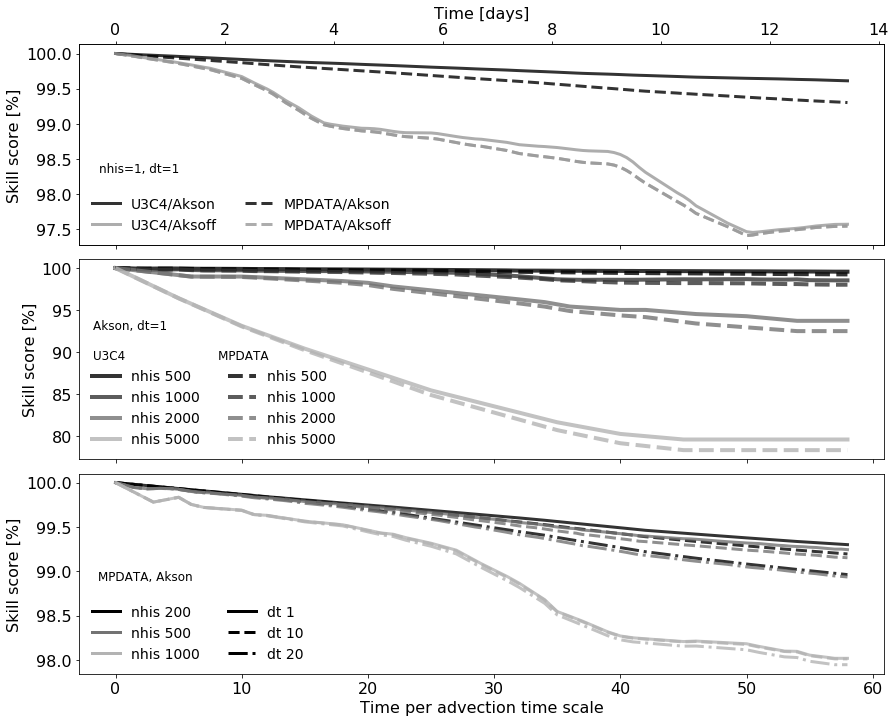

In [24]:
fig, axes = plt.subplots(3,1,figsize=(12,10), sharex=True)#, sharey=True)

# demonstrate tracer advection schemes and Aks forcing for nhis/dt=1
ax = axes[0]
ax.plot(df[iAksonMPDATA], colAkson, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(df[iAksoffMPDATA], colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(df[iAksonU3C4], colAkson, alpha=alpha, ls=lsU3C4, lw=3)
ax.plot(df[iAksoffU3C4], colAksoff, alpha=alpha, ls=lsU3C4, lw=3)

ax.plot([], label="U3C4/Akson", color=colAkson, alpha=alpha, ls=lsU3C4, lw=3)  
ax.plot([], label="U3C4/Aksoff", color=colAksoff, alpha=alpha, ls=lsU3C4, lw=3)  
ax.plot([], label="MPDATA/Akson", color=colAkson, alpha=alpha, ls=lsMPDATA, lw=3)  
ax.plot([], label="MPDATA/Aksoff", color=colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)  

# add second x axis labels on top
ax2 = ax.twiny()
ax2.set_xbound(ax.get_xbound())
dayticks = np.arange(0,16,2)
Tticks = dayticks*86400/T  # normalize time by dynamic time scale
ax2.set_xticks(Tticks)
ax2.set_xticklabels(dayticks)
ax2.set_xlabel('Time [days]', fontsize=fsb)



# demonstrate overall spread of nhis for dt=1
ax = axes[1]
for col, label, color, ls in zip(colsnhis, labelsnhis, colorsnhis, lsnhis):#, colstc, colstls):
    ax.plot(df[col], label=label, color=color, alpha=alpha, lw=4, ls=ls)

    

# demonstrate spread of dt for a few important nhis
ax = axes[2]

for col, c, ls, label in zip(colst, colorst, lst, labelst):
    ax.plot(df[col], color=c, alpha=alpha, ls=ls, lw=3)
for c, nhis in zip(colors, nhist):
    ax.plot([], label="nhis %i" % nhis, color=c, lw=3)
for ls, dt in zip(lss, dtss):
    ax.plot([], label="dt %i" % dt, color='k', lw=3, ls=ls)


ax.set_xlabel('Time per advection time scale', fontsize=16)

fig.tight_layout()

for ax,legendtitle in zip(axes.flat,legendtitles):
    ax.tick_params(labelsize=16)
    ax.legend(title=legendtitle, title_fontsize=fss, fontsize=fsm, ncol=2, framealpha=0)
    ax.set_ylabel('Skill score [%]', fontsize=16)
ax2.tick_params(labelsize=16)

fig.savefig('figures/ss.pdf', bbox_inches='tight')

The best performance comes from the U3C4 tracer advection schemes (though MPDATA is similar) and forcing realistic Aks values from the online case. 

The importance of nhis is low as nhis increases until 200. As nhis increases beyond 200, there is a noticeable decrease in skill score with nhis=500, though performance is reasonably high still, but as nhis increases beyond 500, performance decreases drastically.

For nhis equal to 200 or less, the offline forcing time step is more important than the nhis value. For example, forcing the offline simulation with nhis=20 and dt=20 performs worse than forcing with nhis=200 and dt=10. So, in our case there is no reason to save output more frequently than nhis=200.



In [25]:
alpha=0.8
whichadvects = ['MPDATA', 'U3C4']
cols = [col for col in df.columns if 'dt50' not in col]

# Tracer advection schemes and Aks forcing or not
iU3C4 = [col for col in cols if 'U3C4' in col and '_nhis1_' in col and 'dt50' not in col 
         and '_nhis5000_' not in col and 'persist' in col]
colU3C4 = 'k'; lsU3C4 = '-'
iMPDATA = [col for col in cols if 'MPDATA' in col and '_nhis1_' in col and 'dt50' not in col 
           and '_nhis5000_' not in col and 'persist' in col]
colMPDATA = '0.6'; lsMPDATA = '--'

iAksonU3C4 = [col for col in iU3C4 if 'Akson' in col]
iAksoffU3C4 = [col for col in iU3C4 if 'Aksoff' in col]
iAksonMPDATA = [col for col in iMPDATA if 'Akson' in col]
lsAkson = '-'; colAkson = 'k'
iAksoffMPDATA = [col for col in iMPDATA if 'Aksoff' in col]
lsAksoff = '-.'; colAksoff = '0.6'


# Tracer advection and nhis variations
colors = ['0.0', '0.2', '0.45', '0.7']
lss = ['-', '--', '-.', ':']
colsnhis = []
colorsnhis = []
labelsnhis = []
lsnhis = []
nhist = [500,1000,2000,5000]  # everything lower than 200 is indistinguishable from 200
for whichadvect,ls in zip(whichadvects,[lsMPDATA,lsU3C4]):
    for (i, nhis), color in zip(enumerate(nhist), colors):
        colsnhis.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt1' in col
                      and not 'dt10' in col and 'Akson' in col and whichadvect in col 
                         and 'persist' in col and '_his_' in col])
        labelsnhis.append('nhis %i' % nhis)
        colorsnhis.append(color)
        lsnhis.append(ls)
        
        


colors = ['0.0', '0.45', '0.7']
colst = []
colorst = []  # colors to go with columns
lst = []  # linestyles to go with columns
labelst = []
nhist = [200,500,1000]  # everything lower than 200 is indistinguishable from 200
dtss = [1, 10, 20]  # dt=2 indistinguishable from dt=1

for (i, nhis), color in zip(enumerate(nhist), colors):
    for dt, ls in zip(dtss, lss):
        if dt>=50 or dt>nhis:
            continue
        if nhis==50 and dt==20:
            continue
        colst.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt%i' % dt in col
                      and not 'dt%i' % (dt*10) in col and 'MPDATA' in col and 'Akson' in col
                      and 'persist' in col and '_his_' in col])
        colorst.append(color)
        lst.append(ls)
        labelst.append('nhis %i/dt %i' % (nhis,dt))

legendtitles = ['nhis=1, dt=1                                              \n',
                'Akson, dt=1\n\nU3C4                  MPDATA                 ',
               'MPDATA, Akson                       \n']


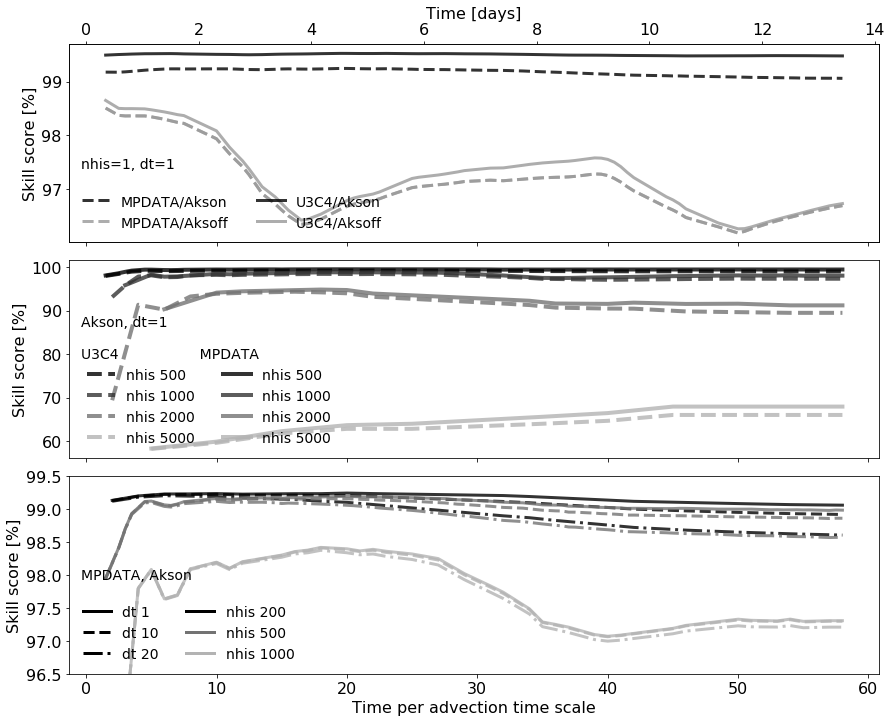

In [26]:
fig, axes = plt.subplots(3,1,figsize=(12,10), sharex=True)#, sharey=True)

# demonstrate tracer advection schemes and Aks forcing for nhis/dt=1
ax = axes[0]
ax.plot(df[iAksonMPDATA], colAkson, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(df[iAksoffMPDATA], colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(df[iAksonU3C4], colAkson, alpha=alpha, ls=lsU3C4, lw=3)
ax.plot(df[iAksoffU3C4], colAksoff, alpha=alpha, ls=lsU3C4, lw=3)

ax.plot([], label="MPDATA/Akson", color=colAkson, alpha=alpha, ls=lsMPDATA, lw=3)  
ax.plot([], label="MPDATA/Aksoff", color=colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)  
ax.plot([], label="U3C4/Akson", color=colAkson, alpha=alpha, ls=lsU3C4, lw=3)  
ax.plot([], label="U3C4/Aksoff", color=colAksoff, alpha=alpha, ls=lsU3C4, lw=3)  



ax2 = ax.twiny()
# Ticks = ax.get_xticks()   
# ax2.set_xticks(Ticks)
ax2.set_xbound(ax.get_xbound())
# 
dayticks = np.arange(0,16,2)
Tticks = dayticks*86400/T  # normalize time by dynamic time scale
ax2.set_xticks(Tticks)
ax2.set_xticklabels(dayticks)
ax2.set_xlabel('Time [days]', fontsize=fsb)



# demonstrate overall spread of nhis for dt=1
ax = axes[1]
for col, label, color, ls in zip(colsnhis, labelsnhis, colorsnhis, lsnhis):#, colstc, colstls):
    ax.plot(df[col], label=label, color=color, alpha=alpha, lw=4, ls=ls)
# ax.legend(title=, ncol=2, fontsize=fsm, framealpha=0, title_fontsize=fsm)


# demonstrate spread of dt for a few important nhis
ax = axes[2]

for col, c, ls, label in zip(colst, colorst, lst, labelst):
    ax.plot(df[col], color=c, alpha=alpha, ls=ls, lw=3)
for ls, dt in zip(lss, dtss):
    ax.plot([], label="dt %i" % dt, color='k', lw=3, ls=ls)
for c, nhis in zip(colors, nhist):
    ax.plot([], label="nhis %i" % nhis, color=c, lw=3)
ax.set_ylim(96.5,99.5)


ax.set_xlabel('Time per advection time scale', fontsize=16)

fig.tight_layout()

for ax,legendtitle in zip(axes.flat,legendtitles):
    ax.tick_params(labelsize=16)
    ax.legend(title=legendtitle, title_fontsize=fsm, fontsize=fsm, ncol=2, framealpha=0, loc='lower left')
    ax.set_ylabel('Skill score [%]', fontsize=16)
ax2.tick_params(labelsize=16)



# Demonstrate other issues

* Plot showing several smaller results:
 * Plot persistence skill score for one example case
 * Forcing on and offline with opposite advection schemes
 * single vs double precision

Use persistence setup from immediately above.

## Mix tracer advection schemes

Compare performance of MPDATA and U3C4 by calculating skill score between them. First treat MPDATA as the "truth" since it is supposed to perform better.

Then compare mixing and matching tracer advection schemes on and offline.

In [27]:
## calculate denominator from online output ##
loconM = '/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis500/oil_03_his'
denomM = calc_denom(loconM, 'regular', save=False)
loconU = '/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his'
denomU = calc_denom(loconU, 'regular', save=False)
numonMU = calc_num(loconM, loconU, save=False)

ssonMU = calc_ss(numonMU, denomM, save=False)
ssonMU['days'] = ssonMU.index
ssonMU.index = ssonMU.index*86400/T  # normalize time by dynamic time scale

# also other combination
ssonUM = calc_ss(numonMU, denomU, save=False)
ssonUM['days'] = ssonUM.index
ssonUM.index = ssonUM.index*86400/T  # normalize time by dynamic time scale


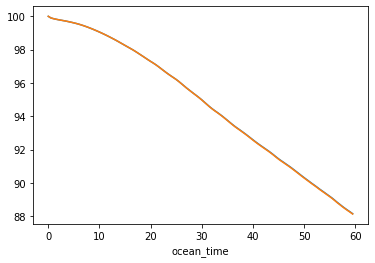

In [28]:
ssonMU['num'].plot()
ssonUM['num'].plot()

This shows that MPDATA and U3C4 give different predictions of the tracer advection, more than many of the offline simulations diverge from their original online simulation.

We expect that MPDATA provides the more accurate solution based on previous studies, but we only consider relative performance here.

### Forcing on and offline with different advection schemes


Plot together:

* online MPDATA/Akson/his/nhis500/oil_off_his.nc --> offline MPDATA/Akson/his/nhis500/oil_off_his_dt20.nc
* online MPDATA/Akson/his/nhis500/oil_off_his.nc --> offline U3C4/Akson/his/nhis500/oil_off_his_dt20B.nc
* online U3C4/Akson/his/nhis500/oil_off_his.nc --> offline U3C4/Akson/his/nhis500/oil_off_his_dt20.nc
* online U3C4/Akson/his/nhis500/oil_off_his.nc --> offline MPDATA/Akson/his/nhis500/oil_off_his_dt20B.nc



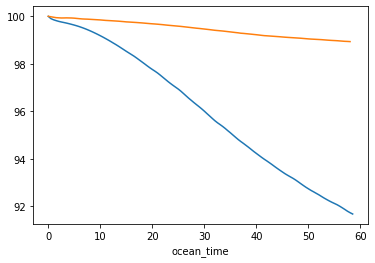

In [29]:
## Compare online MPDATA with offline U3C4 ##
loconM = '/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis500/oil_03_his'
denomM = calc_denom(loconM, 'regular', save=False)
locoffU = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4_forced_by_MPDATA/Akson/his/nhis500/oil_off_his_dt20.nc'
numMU = calc_num(loconM, locoffU, save=False)
ssMU = calc_ss(numMU, denomM, save=False)
ssMU['days'] = ssMU.index
ssMU.index = ssMU.index*86400/T  # normalize time by dynamic time scale
ax = ssMU['num'].plot()
# compare vs. online MPDATA--offline MPDATA
ax.plot(df['MPDATA_Akson_his_nhis500_dt20_reg'])

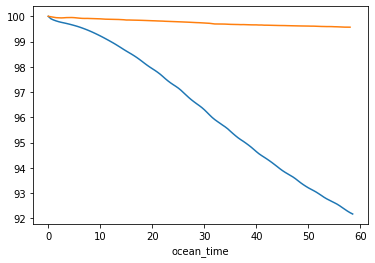

In [30]:
## Compare online U3C4 with offline MPDATA ##
loconU = '/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his'
denomU = calc_denom(loconU, 'regular', save=False)
locoffM = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA_forced_by_U3C4/Akson/his/nhis500/oil_off_his_dt20.nc'
numUM = calc_num(loconU, locoffM, save=False)
ssUM = calc_ss(numUM, denomU, save=False)
ssUM['days'] = ssUM.index
ssUM.index = ssUM.index*86400/T  # normalize time by dynamic time scale
ax = ssUM['num'].plot()
# compare vs. online U3C4--offline U3C4
ax.plot(df['U3C4_Akson_his_nhis500_dt20_reg'])

### Compare tracer advection scheme variations

- U/U DONE
- U/M DONE
- M/U DONE
- M/M DONE
- U/M (online) DONE

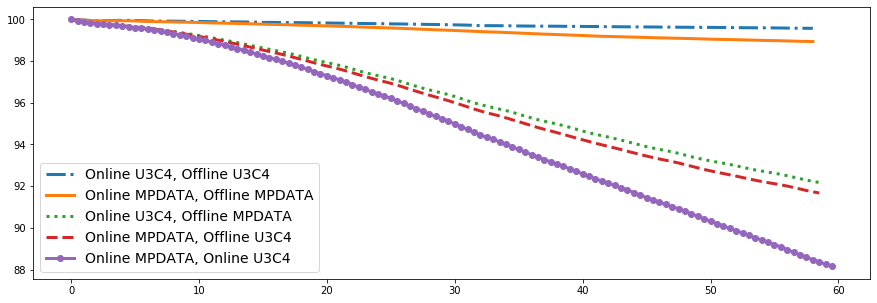

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

# compare vs. online U3C4--offline U3C4
ax.plot(df.index, df['U3C4_Akson_his_nhis500_dt20_reg'], lw=3, ls='-.', label='Online U3C4, Offline U3C4')

# compare vs. online MPDATA--offline MPDATA
ax.plot(df.index, df['MPDATA_Akson_his_nhis500_dt20_reg'], lw=3, ls='-', label='Online MPDATA, Offline MPDATA')

ax.plot(ssUM['num'], lw=3, ls=':', label='Online U3C4, Offline MPDATA')

ax.plot(ssMU['num'], lw=3, label='Online MPDATA, Offline U3C4', ls='--')

ax.plot(ssonMU['num'], lw=3, marker='o', label='Online MPDATA, Online U3C4')

ax.legend(loc='best', fontsize=fsm)

## Double vs single precision

In [32]:
locon2 = '%s/output_ss/MPDATA/nhis500/oil_03_his' % baseon
locon1 = '%s/output_ss/MPDATA/nhis500/oil_03_his_single.nc' % baseon

locoff1 = '%s/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt1_single.nc' % baseoff
locoff2 = '%s/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt1.nc' % baseoff

### Skill score, single vs double precision

The single precision offline nhis500 simulations with 3 different dt values are essentially the same as each other for skill score (to 1e-4). 
The skill score for the double precision offline case (nhis500, dt1, double precision) is much higher than the same with single precision: final skill score after 13.5 days of 98% vs 91%.

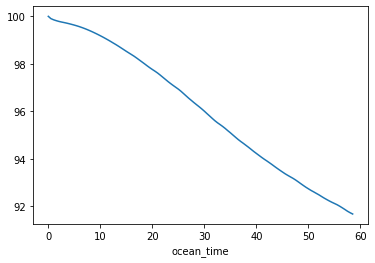

In [33]:
# Offline single precision compared to online double precision
denomon2 = calc_denom(locon2, 'regular', save=False)
num21 = calc_num(locon2, locoff1, save=False)
ss21 = calc_ss(num21, denomon2, save=False)
ss21['days'] = ss21.index
ss21.index = ss21.index*86400/T  # normalize time by dynamic time scale

ss21['num'].plot()

/scratch/user/kthyng/.conda/envs/cart/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


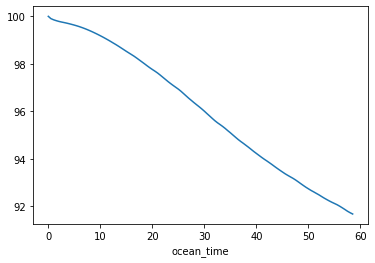

In [34]:
# Offline single precision compared to online single precision
denomon1 = calc_denom(locon1, 'regular', save=False)
num11 = calc_num(locon1, locoff1, save=False)#[:-1]
ss11 = calc_ss(num11, denomon1, save=False)
ss11['days'] = ss11.index
ss11.index = ss11.index*86400/T  # normalize time by dynamic time scale
ss11['num'].plot()


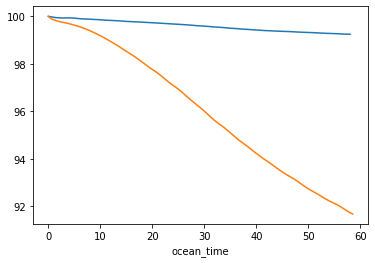

In [35]:
ax = df[find_name(locoff2)+'_reg'].plot(label='double precision')
ss11['num'].plot(ax=ax, label='single precision')
fig.legend()

## Plot

In [36]:
legendtitles = ['nhis=1, dt=1       ',
                '',
               'Precision']
ncols = [1,2,2]

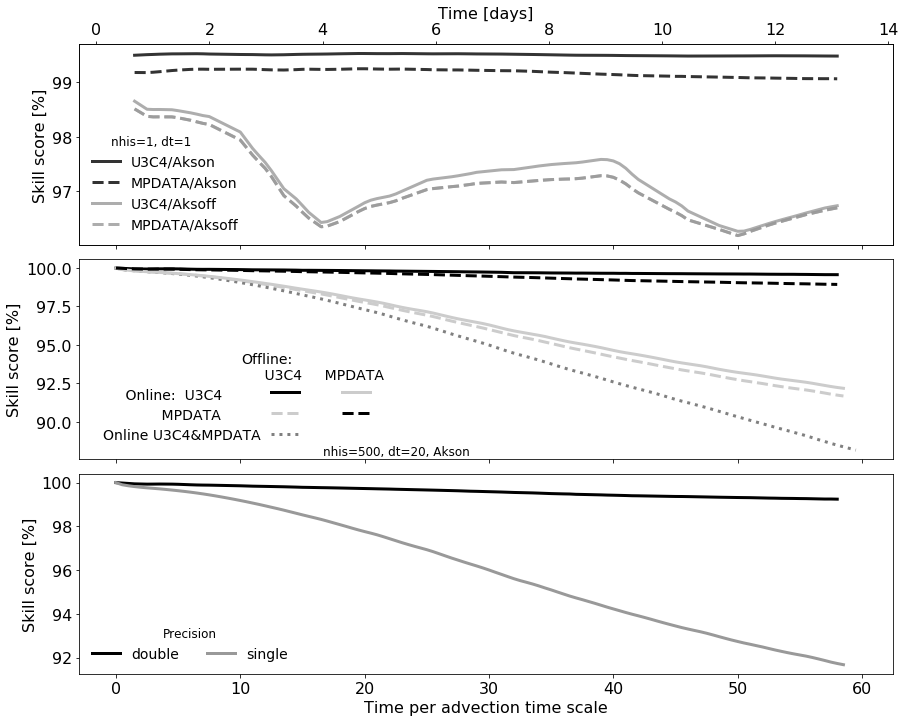

In [37]:
fig, axes = plt.subplots(3,1,figsize=(12,10), sharex=True)#, sharey=True)

# persistence-based skill score
# demonstrate tracer advection schemes and Aks forcing for nhis/dt=1
ax = axes[0]
ax.plot(df[iAksonMPDATA], colAkson, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(df[iAksoffMPDATA], colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(df[iAksonU3C4], colAkson, alpha=alpha, ls=lsU3C4, lw=3)
ax.plot(df[iAksoffU3C4], colAksoff, alpha=alpha, ls=lsU3C4, lw=3)

ax.plot([], label="U3C4/Akson", color=colAkson, alpha=alpha, ls=lsU3C4, lw=3)  
ax.plot([], label="MPDATA/Akson", color=colAkson, alpha=alpha, ls=lsMPDATA, lw=3)  
ax.plot([], label="U3C4/Aksoff", color=colAksoff, alpha=alpha, ls=lsU3C4, lw=3)  
ax.plot([], label="MPDATA/Aksoff", color=colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)  

ax2 = ax.twiny()
ax2.set_xbound(ax.get_xbound())
dayticks = np.arange(0,16,2)
Tticks = dayticks*86400/T  # normalize time by dynamic time scale
ax2.set_xticks(Tticks)
ax2.set_xticklabels(dayticks)
ax2.set_xlabel('Time [days]', fontsize=fsb)


# compare using opposite advection schemes
coth = '0.8'
ax = axes[1]
# compare vs. online U3C4--offline U3C4
ax.plot(df.index, df['U3C4_Akson_his_nhis500_dt20_reg'], lw=3, 
        color=colAkson, ls=lsU3C4, label=' ')#Online U3C4, Offline U3C4')
ax.plot(ssMU.index, ssMU['num'], lw=3, color=coth, ls=lsMPDATA,
        label=' ')#Online MPDATA, Offline U3C4')
ax.plot(ssonMU.index, ssonMU['num'], lw=3, ls=':',color='0.5',
        label=' ')#Online MPDATA, Online U3C4')
ax.plot(ssUM.index, ssUM['num'], lw=3, ls=lsU3C4, color=coth,
        label=' ')#Online U3C4, Offline MPDATA')
# compare vs. online MPDATA--offline MPDATA
ax.plot(df.index, df['MPDATA_Akson_his_nhis500_dt20_reg'], lw=3, ls=lsMPDATA, 
        color=colAkson, label=' ')#Online MPDATA, Offline MPDATA')
ax.text(0.3, 0.02, 'nhis=500, dt=20, Akson', fontsize=fss, transform=ax.transAxes)
ax.legend(title_fontsize=fss, fontsize=fsm, ncol=ncols[1], 
          framealpha=0, loc='lower left', bbox_to_anchor=(0.22, 0.025))
ax.text(0.03,0.3, '     Online:  U3C4', transform=ax.transAxes, fontsize=fsm)
ax.text(0.03,0.2, '             MPDATA', transform=ax.transAxes, fontsize=fsm)
ax.text(0.03,0.1, 'Online U3C4&MPDATA', transform=ax.transAxes, fontsize=fsm)
ax.text(0.2,0.4, 'Offline:\n     U3C4     MPDATA', transform=ax.transAxes, fontsize=fsm)



# Compare skill score for double vs single precision
ax = axes[2]
ax.plot(df[find_name(locoff2)+'_reg'], color='k', label='double', lw=3)
ax.plot(ss11['num'], color='0.6', label='single', lw=3)



ax.set_xlabel('Time per advection time scale', fontsize=16)

fig.tight_layout()
i=0
for ax,legendtitle,ncol in zip(axes.flat,legendtitles,ncols):
    ax.tick_params(labelsize=16)
    if i!=1:
        ax.legend(title=legendtitle, title_fontsize=fss, fontsize=fsm, ncol=ncol, framealpha=0, loc='lower left')
    ax.set_ylabel('Skill score [%]', fontsize=16)
    i += 1
ax2.tick_params(labelsize=16)

fig.savefig('figures/other.pdf', bbox_inches='tight')


## Background value of Aks doesn't matter

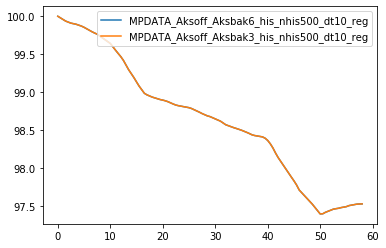

In [38]:
cols = [col for col in df.columns if 'Aksbak' in col and '_his_' in col and 'MPDATA' in col 
        and 'nhis500_' in col and 'reg' in col and 'dt10' in col]
df[cols].plot()

## his vs avg

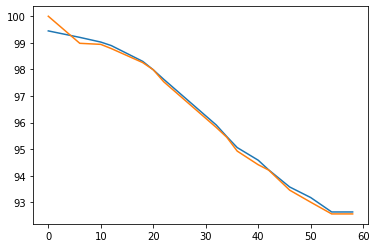

In [39]:
ax = df['MPDATA_Akson_avg_nhis2000_dt20_reg'].plot()
df['MPDATA_Akson_his_nhis2000_dt20_reg'].plot(ax=ax)

## Tracer conservation

 * online one of the runs MPDATA and U3C4, then compare with highest offline (nhis1) and with nhis500/dt1/10/20

Do a separate set of downscaling without subsamping in space for this test


Tracer conservation is the same for on and offline.

MPDATA different on and offline -- test for a different nhis value

In [40]:
locsont = glob('%s/output_ss/*/nhis1/oil_03_???' % baseon)
locsont

['/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_avg',
 '/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_his',
 '/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his']

In [41]:
for locon in set(locsont):
    nhis = int(locson[0].split('/')[8].split('nhis')[1])

    dd = int(500/nhis)
    zarrname = locon.split('.')[0] + '_fulldomain'
    
    if not os.path.exists(zarrname):  # don't redo
        print('processing %s...' % zarrname)
        dson = xr.open_dataset(locon, decode_times=False, chunks=chunks);
        dyeon = calc_dyevol(dson)
        dyeon.isel(ocean_time=slice(0,-1,dd)).to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
    else:
        print('already done with %s, moving on.' % zarrname)


already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_his_fulldomain, moving on.
already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his_fulldomain, moving on.
already done with /scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_avg_fulldomain, moving on.


In [42]:
locsont = glob('%s/output_ss/*/nhis1/*_fulldomain' % baseon)
locsont

['/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_avg_fulldomain',
 '/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_his_fulldomain',
 '/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his_fulldomain']

In [43]:
locsofft = glob('%s/output_ss/*/Akson/*/nhis500/*.nc' % baseoff)
locsofft = [File for File in locsofft if 'forced' not in File 
            and 'B.nc' not in File and '_single' not in File 
            and 'dt2.' not in File and 'dt50' not in File and 'dt5' not in File]
locsofft

['/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt10.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt20.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt1.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis500/oil_off_avg_dt1.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis500/oil_off_avg_dt20.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis500/oil_off_avg_dt10.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt10.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt20.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt1.nc']

In [44]:

names = []
dyes = np.zeros((ind.size, len(locsofft) + len(locsont)))
i = 0
for locon in locsont:

    names.append(find_name(locon))
    ds = xr.open_zarr(locon.split('.')[0], decode_times=False, chunks=chunks)
    dyesumon = ds.dye_01.sum(('s_rho', 'eta_rho', 'xi_rho'))  # already volumetric
    dyesumon['ocean_time'] = (dyesumon.ocean_time - dyesumon.ocean_time[0])/86400
    dyes[:,i] = dyesumon.sel(ocean_time=slice(0,tend)).values
    i += 1


for locoff in locsofft:

    names.append(find_name(locoff))
    dsoff = xr.open_dataset(locoff, decode_times=False)
    dyeoff = calc_dyevol(dsoff)
    dyesumoff = dyeoff.sum(('s_rho', 'eta_rho', 'xi_rho'))
    dyesumoff['ocean_time'] = (dyesumoff.ocean_time - dyesumoff.ocean_time[0])/86400
    dyes[:,i] = dyesumoff.sel(ocean_time=slice(0,tend)).values
    i += 1
    


In [45]:
dftracer = pd.DataFrame(index=dyesumoff.ocean_time.sel(ocean_time=slice(0,tend)), data=dyes, columns=names)
dftracer


,MPDATA_nhis1_avg,MPDATA_nhis1_his,U3C4_nhis1_his,MPDATA_Akson_his_nhis500_dt10,MPDATA_Akson_his_nhis500_dt20,MPDATA_Akson_his_nhis500_dt1,MPDATA_Akson_avg_nhis500_dt1,MPDATA_Akson_avg_nhis500_dt20,MPDATA_Akson_avg_nhis500_dt10,U3C4_Akson_his_nhis500_dt10,U3C4_Akson_his_nhis500_dt20,U3C4_Akson_his_nhis500_dt1
ocean_time,,,,,,,,,,,,
0.000000,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13
0.115741,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13
0.231481,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13,2.281464e+13
...,...,...,...,...,...,...,...,...,...,...,...,...
13.194444,2.277003e+13,2.277003e+13,2.277822e+13,2.274685e+13,2.274675e+13,2.274696e+13,2.274464e+13,2.274434e+13,2.274448e+13,2.277821e+13,2.277823e+13,2.277818e+13
13.310185,2.276627e+13,2.276627e+13,2.277477e+13,2.274218e+13,2.274208e+13,2.274229e+13,2.273990e+13,2.273960e+13,2.273975e+13,2.277476e+13,2.277478e+13,2.277473e+13
13.425926,2.276212e+13,2.276212e+13,2.277129e+13,2.273739e+13,2.273730e+13,2.273750e+13,2.273507e+13,2.273479e+13,2.273492e+13,2.277127e+13,2.277130e+13,2.277124e+13


In [46]:
cols = dftracer.columns
iM = [col for col in cols if 'MPDATA' in col]
iU = [col for col in cols if 'U3C4' in col]
iMavg = [col for col in iM if '_avg' in col]
iMhis = [col for col in iM if '_his' in col]
iMon = [col for col in iM if 'dt' not in col]
iMoff = [col for col in iM if 'dt' in col]

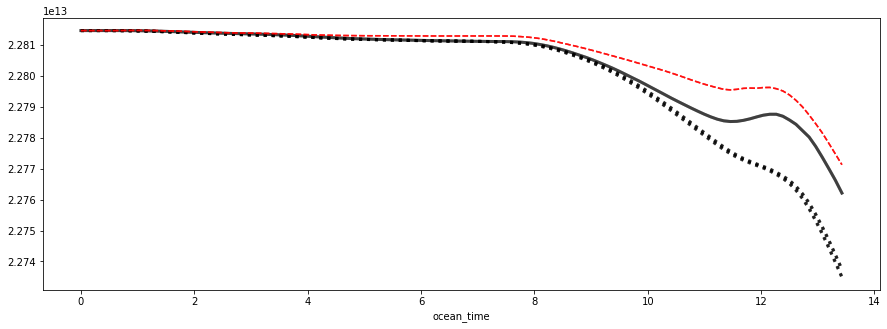

In [47]:
ax = dftracer[iMon].plot(figsize=(15,5), legend=False, color='k', lw=3, alpha=0.5)
dftracer[iMoff].plot(color='k', lw=3, alpha=0.5, ls=':', ax=ax, legend=False)
dftracer[iU].plot(color='r', ls='--', alpha=0.5, ax=ax, legend=False)

# Compare run time, storage, and skill score

## Read in times for runs from log files

Both wall times and computational times

First get multi index for the times dataframe.

In [67]:
idxlist = []
Files = glob('%s/log/ss_*_Akso*_his_nhis*_dt*.*' % (baseoff))
Files = [File for File in Files if not 'single' in File and not 'onlinewasU3C4' in File and not 'B' in File
        and 'nhis5_dt2' not in File and 'nhis50_dt20' not in File and 'Aksbak3' not in File and 'dt50' not in File]
# online files
Fileson = glob('%s/log/ss_*_nhis*.*' % (baseon))
Fileson = [File for File in Fileson if not 'single' in File]
Files += Fileson

for File in Files:

    if 'oil_03' in File:
        kind = 'on'
        whichadvect, nhisp = File.split('/')[-1].split('_')[1:]
        dt = 1
        nhis = int(nhisp.split('.')[0].split('nhis')[1])
        aks = 'na'
    elif 'oil_off' in File:
        if 'Aksbak' in File:
            whichadvect, _, _, _, nhisp, dtp = File.split('/')[-1].split('_')[1:]
            aks = 'off'
        else:
            whichadvect, _, _, nhisp, dtp = File.split('/')[-1].split('_')[1:]
            aks = 'on'
        kind = 'off'
        dt = int(dtp.split('.')[0].split('dt')[1])
        nhis = int(nhisp.split('nhis')[1])
    
    idxlist.append((nhis, dt, whichadvect, kind, aks))

idx = pd.MultiIndex.from_tuples(idxlist, names=['nhis','dt','advect','kind','aks'])

## Plot

In [68]:
rowslist = []; 
cols = ['walltime [s]', 'comptime [s]', 'storage [GB/day]', 'ss']
dft = pd.DataFrame(index=idx, columns=cols, dtype=float)

for ids, File in zip(idxlist, Files):
    nhis, dt, whichadvect, kind, aks = ids

    f = open(File, "r")
    lines = f.readlines()
    start = pd.Timestamp(lines[2])
    stop = pd.Timestamp(lines[-1].split('DONE...')[-1])
    walltime = stop - start

    comptime = float([line for line in lines if "All percentages are with respect to total time = " in line][0].split('=')[-1])
    dft.loc[nhis,dt, whichadvect, kind, aks][cols[0]] = walltime.total_seconds()  # seconds
    dft.loc[nhis,dt, whichadvect, kind, aks][cols[1]] = comptime  # seconds

    if aks == 'on':
        num3d = 4
        name = '%s_Aks%s_his_nhis%i_dt%i_reg' % (whichadvect,aks,nhis,dt)  # ss col name
    elif aks == 'off':
        num3d = 3
        name = '%s_Aks%s_Aksbak6_his_nhis%i_dt%i_reg' % (whichadvect,aks,nhis,dt)  # ss col name
    else:
        num3d = 4  # assume higher storage for online sim for plot
    
    # Calculate storage required for online simulation only (since doesn't change for offline)
    # times number of outputs per day
    noutputs = 86400/(20*nhis)  # sec/day and 20 is the online simulation timestep. Gives #outputs per day.
    S = calc_storage(Lm*Mm, N, num3d, nbytes)*noutputs
    
    dft.loc[nhis,dt, whichadvect, kind, aks][cols[2]] = S
    
    # select skill score from df
    if kind == 'on':
        pass  # online simulation
    elif kind == 'off':
        dft.loc[nhis,dt, whichadvect, kind, aks][cols[3]] = df.iloc[-1].loc[name]
    
dft['nhis'] = dft.index.get_level_values(0)  # for convenience later
dft['t [s/day]'] = dft['comptime [s]']/ndays
dft['dt'] = dft.index.get_level_values(1)  # for convenience later

# shift one data point over so it will be visible in the plot
dft.loc[(200,20,'MPDATA','off','on'),['t [s/day]']] -= 150
dft.loc[(10,5,'U3C4','off','on'),['t [s/day]']] += 200
dft.loc[(10,10,'MPDATA','off','on'),['t [s/day]']] -= 150
dft.loc[(20,10,'U3C4','off','on'),['t [s/day]']] += 150
dft.loc[(20,10,'MPDATA','off','on'),['t [s/day]']] += 100
dft.loc[(20,20,'U3C4','off','on'),['t [s/day]']] -= 100
dft.loc[(50,10,'MPDATA','off','on'),['t [s/day]']] -= 50
dft.loc[(1000,10,'U3C4','off','on'),['t [s/day]']] += 25
dft.loc[(500,5,'U3C4','off','on'),['t [s/day]']] += 100


/scratch/user/kthyng/.conda/envs/cart/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [69]:

import cmocean.tools
ncons = 8
cmap = cmo.thermal
rgb = cmap(np.linspace(0,1,ncons))
cmap = cmocean.tools.cmap(rgb, N=ncons)
vmax = 99.6; vmin = 97.2  # to make even contour bounds

cmap

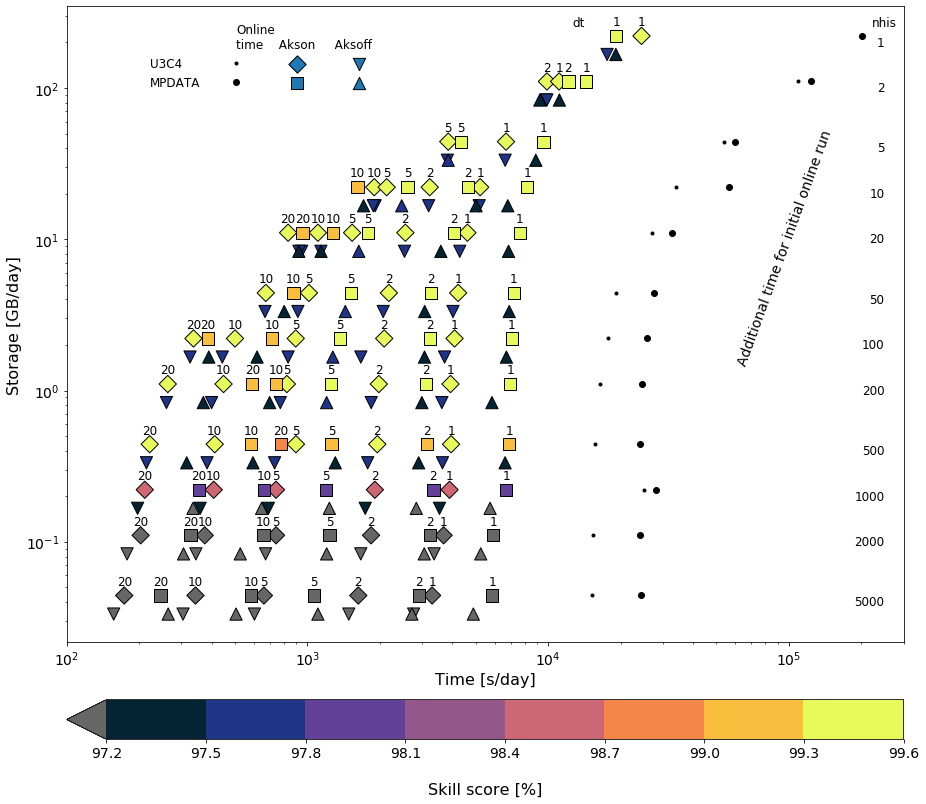

In [73]:
fig, ax = plt.subplots(1,1,figsize=(15,15))

# round all results to 1 decimal place
subonU = dft.query('advect=="U3C4" and aks=="on" and kind=="off"')
ax.scatter(subonU['t [s/day]'], subonU['storage [GB/day]'], c=subonU['ss'].round(1), s=ms, cmap=cmap, marker='D', 
           vmin=vmin, vmax=vmax, edgecolors='k', label=' ')  # Akson

subonM = dft.query('advect=="MPDATA" and aks=="on" and kind=="off"')
ax.scatter(subonM['t [s/day]'], subonM['storage [GB/day]'], c=subonM['ss'].round(1), s=ms, cmap=cmap, marker='s', 
           vmin=vmin, vmax=vmax, edgecolors='k', label=' ')  # Akson

subU = dft.query('advect=="U3C4" and aks=="off" and kind=="off"')
mappable = ax.scatter(subU['t [s/day]'], subU['storage [GB/day]'], c=subU['ss'].round(1), s=ms, cmap=cmap, marker='v', 
                      vmin=vmin, vmax=vmax, edgecolors='k', label=' ')  # Aksoff

subM = dft.query('advect=="MPDATA" and aks=="off" and kind=="off"')
mappable = ax.scatter(subM['t [s/day]'], subM['storage [GB/day]'], c=subM['ss'].round(1), s=ms, cmap=cmap, marker='^', 
                      vmin=vmin, vmax=vmax, edgecolors='k', label=' ')  # Aksoff

ax.set_yscale('log')
ax.set_xscale('log')


ax.set_xlabel('Time [s/day]', fontsize=fsb)
ax.set_ylabel('Storage [GB/day]', fontsize=fsb)

cb = fig.colorbar(mappable, pad=0.07, ticks=np.linspace(vmin, vmax, ncons+1), extend='min', 
                  ax=ax, orientation='horizontal')
mappable.cmap.set_under('0.4')
cb.set_label('\nSkill score [%]', fontsize=fsb)
cb.ax.tick_params(labelsize=fsm)

ax.tick_params(labelsize=fsm)

ax.set_xlim(100,3e5)
# ax.set_ylim(0.01, 350)

# Loop over rows when the nhis value changes create text annotations.
i = 0
xnhis = 2.5e5
loops = np.unique(subonU[['storage [GB/day]','nhis']].values, axis=0)
for y, z in loops:
    i+=1
    if i==len(loops):
        text = ax.text(xnhis, y*1.1, 'nhis', ha="center", va="bottom", color="k", fontsize=fss)
    text = ax.text(xnhis, y, '%i'%z, ha="right", va="top", color="k", fontsize=fss)
    
    
loops = subonU[['t [s/day]','storage [GB/day]','dt','nhis']].values
for x, y, z, nhis in loops:
#     if z==1 and nhis==1:
#         text = ax.text(x*0.7, y*1.1, 'dt', ha="center", va="bottom", color="k", fontsize=fss)
    text = ax.text(x, y*1.12, '%i'%z, ha="center", va="bottom", color="k", fontsize=fss)
loops = subonM[['t [s/day]','storage [GB/day]','dt','nhis']].values
for x, y, z, nhis in loops:
    if z==1 and nhis==1:
        text = ax.text(x*0.7, y*1.1, 'dt', ha="center", va="bottom", color="k", fontsize=fss)
    text = ax.text(x, y*1.12, '%i'%z, ha="center", va="bottom", color="k", fontsize=fss)
    
dfts = dft.query('advect=="U3C4" and aks=="na" and kind=="on"')
ax.loglog(dfts['t [s/day]'], dfts['storage [GB/day]'], 'k', marker='.', ls='', label=' ')  # online time
dfts = dft.query('advect=="MPDATA" and aks=="na" and kind=="on"')
ax.loglog(dfts['t [s/day]'], dfts['storage [GB/day]'], 'k', marker='o', ls='', label=' ')  # online time
   
ax.legend(loc='upper left', bbox_to_anchor=(0.175, 0.99), fontsize=fss, ncol=3, 
          title='Online\ntime    Akson     Aksoff', framealpha=0, title_fontsize=fss)
ax.text(0.1, 0.92, 'U3C4', transform=ax.transAxes, fontsize=fss, 
        horizontalalignment='left', verticalalignment='top')
ax.text(0.1, 0.89, 'MPDATA', transform=ax.transAxes, fontsize=fss, 
        horizontalalignment='left', verticalalignment='top')

ax.text(6e4, 1.5, 'Additional time for initial online run', rotation=70, fontsize=fsm);

fig.savefig('figures/sum_low.png', bbox_inches='tight', dpi=100)
fig.savefig('figures/sum.png', bbox_inches='tight', dpi=300)
fig.savefig('figures/sum.pdf', bbox_inches='tight')

Time and storage is given on a per day basis so would need to be multiplied out for the number of days of simulation. On and offline simulation time is shown separately since the online simulation time needs to occur only once for any number of offline simulations. The storage is shown only for the online simulation since the offline simulation can be put out at whatever the user chooses (though the user should output both dye_01 and zeta to recreate the dye field properly).

## Print tables of results

In [52]:
# have to add [t] to table files
dfts = dft.query('kind=="off"')
dfts.index.names = ['nhis','dt','advect','kind','Aks']
# dfts
isort = dfts.index.sortlevel('nhis')
dfts2 = dfts['ss'].iloc[(isort[1])]
dfts2

dfts3 = dfts2.reset_index().pivot_table(index=['nhis','dt'], 
                                columns=['advect','Aks'])['ss']
dfts3.loc[[1,2,5,10,20,50,100,200]].to_latex('output_ss/table1.tex', float_format="%.1f")
dfts3.loc[[500,1000,2000,5000]].to_latex('output_ss/table2.tex', float_format="%.1f")


# Interpretation of nhis behavior

Get a sample speed signal from middle of analysis patch for calculating power spectral density.

In [53]:
fname = 'output_ss/speed.csv'
if os.path.exists(fname):
    dfs = pd.read_csv(fname, index_col=0)
else:
    loc = '/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his.nc'
    ds = xr.open_dataset(loc, decode_times=False, chunks=chunks)

    u = ds.u.isel(eta_u=40, xi_u=60, s_rho=-1)
    v = ds.v.isel(eta_v=40, xi_v=60, s_rho=-1)
    uu = u.values
    vv = v.values
    dfs = pd.DataFrame(index=ds.ocean_time, data={'u': uu, 'v': vv})
    dfs.to_csv()

In [54]:
s = np.sqrt(dfs['u']**2 + dfs['v']**2)

dt = (dfs.index[1] - dfs.index[0])
Fs = 1/dt;  # sampling rate

# Calculate power spectral density
# https://scipy.github.io/devdocs/generated/scipy.signal.periodogram.html#scipy.signal.periodogram
f, Pxx_den = signal.periodogram(s, Fs, scaling='density')
dff = pd.DataFrame(index=f, data={'P': Pxx_den})


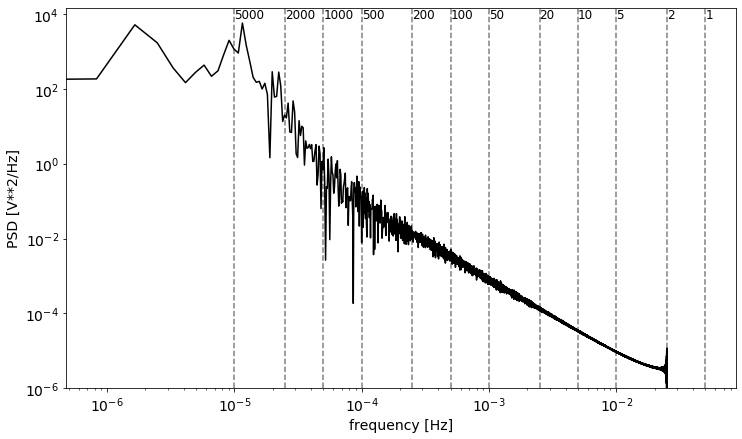

In [55]:
fig, ax = plt.subplots(1,1, figsize=(12,7))

# plot the power spectrum
ax.loglog(f, dff['P'], color='k')
ax.set_ylim(1e-6,1e4)
ax.set_xlabel('frequency [Hz]', fontsize=fsm)
plt.ylabel('PSD [V**2/Hz]', fontsize=fsm)
ylims = list(ax.get_ylim())
ylims[1] *= 1.5
plt.tick_params(labelsize=fsm)
ax.set_ylim(*ylims)

for nhis in nhiss:
    ax.vlines(fnhis(nhis), *ylims, color='0.5', ls='--')
    ax.text(fnhis(nhis), 8e3, nhis, fontsize=fss)

fig.savefig('figures/spectrum.pdf', bbox_inches='tight')

In [56]:
for nhis in nhiss:
    frqnhis = fnhis(nhis)
    print(nhis,(dff[frqnhis:].sum()/dff[:frqnhis].sum())*100)

1 P    0.0
dtype: float64
2 P    0.0
dtype: float64
5 P    0.000364
dtype: float64
10 P    0.000815
dtype: float64
20 P    0.001675
dtype: float64
50 P    0.00415
dtype: float64
100 P    0.008365
dtype: float64
200 P    0.017151
dtype: float64
500 P    0.044901
dtype: float64
1000 P    0.130152
dtype: float64
2000 P    1.084161
dtype: float64
5000 P    82.877659
dtype: float64


# Make a function for storage and time

## Storage

nvariables * number outputs per day, show on per day basis (cross-section of sum plot)
follow mitgcm for times

Text(0.5, 0, 'online output frequency [nhis, multiple of online time step]')

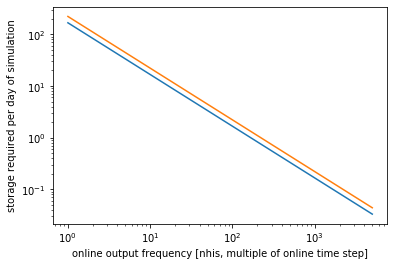

In [57]:
# Calculate storage required for online simulation only (since doesn't change for offline)
# times number of outputs per day
noutputs = 86400/(20*np.array(nhiss))  # sec/day and 20 is the online simulation timestep. Gives #outputs per day.
num3d = 3
S3 = calc_storage(Lm*Mm, N, num3d, nbytes)*noutputs
num3d = 4
S4 = calc_storage(Lm*Mm, N, num3d, nbytes)*noutputs
plt.loglog(nhiss,S3)
plt.loglog(nhiss,S4)
plt.ylabel('storage required per day of simulation')
plt.xlabel('online output frequency [nhis, multiple of online time step]')

## Times

What is the speed up gained from running offline vs. online, though accounting for the necessary online case?

In [58]:
dft

,,,,,walltime [s],comptime [s],storage [GB/day],ss,nhis,t [s/day],dt
nhis,dt,advect,kind,aks,,,,,,,
200,5,U3C4,off,on,825.0,11513.427,1.104970,99.610054,200,822.387643,5
20,2,MPDATA,off,on,4106.0,57129.455,11.049696,99.299943,20,4080.675357,2
200,2,U3C4,off,off,1848.0,25794.002,0.832810,97.568577,200,1842.428714,2
...,...,...,...,...,...,...,...,...,...,...,...
100,1,U3C4,on,na,2953.0,247812.504,2.209939,NaN,100,17700.893143,1
10,1,MPDATA,on,na,9456.0,793547.343,22.099392,NaN,10,56681.953071,1
200,1,U3C4,on,na,2736.0,229692.845,1.104970,NaN,200,16406.631786,1


In [59]:
dts, nhiss

([1, 2, 5, 10, 20], [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000])

Text(0, 0.5, '')

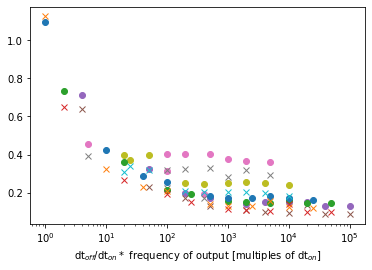

In [60]:
fig, ax = plt.subplots(1,1)

tonM0 = dft['comptime [s]'].loc[1,1,'MPDATA','on','na']
tonU0 = dft['comptime [s]'].loc[1,1,'U3C4','on','na']

for nhis in nhiss:
    for dt in dts:
        if dt>nhis or (nhis==5 and dt==2) or (nhis==50 and dt==20):
            continue
        x = dt*nhis  # ratio of offline to online ts * ratio of output to online time step
        ton = dft['comptime [s]'].loc[nhis,1,'MPDATA','on','na']
        yM = dft['comptime [s]'].loc[nhis,dt,'MPDATA','off','on']/ton + ton/tonM0
#         yM = (dft['comptime [s]'].loc[nhis,dt,'MPDATA','off','on'] )/tonM0
        ton = dft['comptime [s]'].loc[nhis,1,'U3C4','on','na']
        yU = dft['comptime [s]'].loc[nhis,dt,'U3C4','off','on']/ton + ton/tonU0
#         yU = (dft['comptime [s]'].loc[nhis,dt,'U3C4','off','on'] )/tonU0
        ax.semilogx(x, yM, 'o')
        ax.semilogx(x, yU, 'x')
        
ax.set_xlabel('dt$_{off}$/dt$_{on}*$ frequency of output [multiples of dt$_{on}$]')
ax.set_ylabel('')

In [61]:
# want xaxis to be nhis, different line for each dt value
# yaxis